In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import the pandas library
import pandas as pd

file_name = "month_data.csv"
# Define the file path
file_path = r"data" + "/" + file_name

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=';', encoding='utf-8')

# Display the first few rows of the DataFrame
print(df.head())


   Tåguppdrag   Datum_PAU Tågslag Tågsort UppehållstypAvgång  \
0      1710.0  2019-03-23     RST  PENDEL           Uppehåll   
1      1710.0  2019-03-27     RST  PENDEL           Uppehåll   
2      1710.0  2019-03-16     RST  PENDEL           Uppehåll   
3       546.0  2019-03-31     RST   SNABB           Uppehåll   
4      7445.0  2019-03-04     RST  REGION            Passage   

  UppehållstypAnkomst  AktivitetskodAvgång AktivitetskodBeskrivningAvgång  \
0               Sista                   11  Av- och påstigande av resande   
1               Sista                   11  Av- och påstigande av resande   
2               Sista                   11  Av- och påstigande av resande   
3             Passage                   11  Av- och påstigande av resande   
4             Passage                    0                              -   

   AktivitetskodAnkomst AktivitetskodBeskrivningAnkomst  ...  \
0                    10           Avstigande av resande  ...   
1                    10 

In [32]:
print(df.columns.tolist())

['Tåguppdrag', 'Datum_PAU', 'Tågslag', 'Tågsort', 'UppehållstypAvgång', 'UppehållstypAnkomst', 'AktivitetskodAvgång', 'AktivitetskodBeskrivningAvgång', 'AktivitetskodAnkomst', 'AktivitetskodBeskrivningAnkomst', 'DelSträckanummer', 'Förstaplatssignatur_för_Uppdrag', 'Sistaplatssignatur_för_Uppdrag', 'Avgångsplats', 'Avgångsplatssignatur', 'Ankomstplats', 'Ankomstplatssignatur', 'PlanAvgTid', 'PlanAnkTid', 'UtfAnkTid', 'UtfAvgTid', 'PlanAnkTid_vid_AvgPlats', 'UtfAnkTid_vid_AvgPlats', 'PlanUppehållstidAvgång', 'UtfUppehållstidAvgång', 'PlanGångtid', 'UtfGångtid', 'FörseningGångtid', 'AvgFörsening', 'AnkFörsening', 'FörseningUppehållAvgång']


In [3]:
#get all rows with tåguppdrag and date
unique_tåguppdrag = df['Tåguppdrag'].unique()
unique_dates = df['Datum_PAU'].unique()
print(len(unique_tåguppdrag), len(unique_dates))
print(unique_tåguppdrag[:10]) 
print(unique_dates[:10])

9584 31
[ 1710.   546.  7445.  7583.   565.   490.  9771.  9804.  2820. 12622.]
['2019-03-23' '2019-03-27' '2019-03-16' '2019-03-31' '2019-03-04'
 '2019-03-30' '2019-03-06' '2019-03-15' '2019-03-26' '2019-03-25']


In [8]:
import pandas as pd



# List of specific mission types interested in
mission_types = [848.0, 20.0, 51.0,25.0, 813.0, 833.0]  # Add or adjust missions as necessary
specific_date = '2019-03-27'  # Change this to desired date
start_time = '7:00:00' 
end_time = '19:00:00'

# Initialize a dictionary to hold routes for each mission
all_routes = {}


# Loop through each mission type
for mission_type in mission_types:
    # Filter the DataFrame based on mission type and specific date
    filtered_df = df[(df['Tåguppdrag'] == mission_type) & (df['Datum_PAU'] == specific_date)].copy()
    
    #convert time column to date time format
    filtered_df['PlanAvgTid'] = pd.to_datetime(filtered_df['PlanAvgTid'], errors='coerce')
    filtered_df['PlanAnkTid'] = pd.to_datetime(filtered_df['PlanAnkTid'], errors='coerce')

    #filter by arrival and depature
    filtered_df = filtered_df[((filtered_df['PlanAvgTid'].dt.time >= pd.to_datetime(start_time).time()) & 
                           (filtered_df['PlanAvgTid'].dt.time <= pd.to_datetime(end_time).time())) |
                          ((filtered_df['PlanAnkTid'].dt.time >= pd.to_datetime(start_time).time()) & 
                           (filtered_df['PlanAnkTid'].dt.time <= pd.to_datetime(end_time).time()))]

    # Initialize a list to hold the routes for the current mission
    routes = []

    # Step 4: Iterate through filtered DataFrame to build routes
    for index, row in filtered_df.iterrows():
        if row['UppehållstypAvgång'] == 'Första':
            # Start the route with the departure station
            current_route = [row['Avgångsplats']]
            
            # Continue to add stations until reach 'Sista'
            next_row = row
            while next_row['UppehållstypAnkomst'] != 'Sista':
                # Find the next station in the DataFrame that matches the current departure station
                next_station = filtered_df[(filtered_df['Avgångsplats'] == next_row['Ankomstplats']) & 
                                           (filtered_df['Tåguppdrag'] == mission_type)]
                
                if not next_station.empty:
                    current_route.append(next_station.iloc[0]['Ankomstplats'])
                    next_row = next_station.iloc[0]  # Move to the next row
                else:
                    break  # Exit if no further stations are found
            
            # If the last station is 'Sista', append it to the route
            if next_row['UppehållstypAnkomst'] == 'Sista':
                current_route.append(next_row['Ankomstplats'])
            
            # Add the complete route to the routes list
            routes.append(" -> ".join(current_route))
    
    # Store the routes for the current mission in the dictionary
    all_routes[mission_type] = routes

# Display the routes for each mission
for mission, routes in all_routes.items():
    print(f"\nRoutes for {mission}:")
    for route in routes:
        print("Route:", route)

#print("filtered data:",(filtered_df)) 



Routes for 848.0:
Route: Stockholm C -> Tomteboda övre -> Solna -> Ulriksdal -> Helenelund -> Kummelby -> Sollentuna -> Häggvik -> Norrviken -> Rotebro -> Upplands Väsby -> Skavstaby -> Rosersberg -> Brista -> Märsta -> Myrbacken -> Knivsta -> Ekeby -> Säby -> Uppsala c -> Uppsala c

Routes for 20.0:
Route: Stockholm C -> Tomteboda övre -> Solna -> Ulriksdal -> Helenelund -> Kummelby -> Sollentuna -> Häggvik -> Norrviken -> Rotebro -> Upplands Väsby -> Skavstaby -> Blackvreten -> Arlanda nedre -> Arlanda Central -> Myrbacken -> Knivsta -> Ekeby -> Säby -> Uppsala c -> Uppsala norra -> Brunna -> Järlåsa -> Morgongåva -> Heby -> Isätra -> Sala -> Broddbo -> Rosshyttan -> Avesta Krylbo -> Avesta Centrum -> Snickarbo -> Hedemora -> Vikmanshyttan -> Säter -> Gustafs -> Stora Tuna -> Borlänge c -> Ornäs -> Hinsnoret -> Falun -> Falun

Routes for 51.0:

Routes for 25.0:
Route: Falun -> Ornäs -> Borlänge c -> Stora Tuna -> Gustafs -> Säter -> Vikmanshyttan -> Hedemora -> Snickarbo -> Avesta C

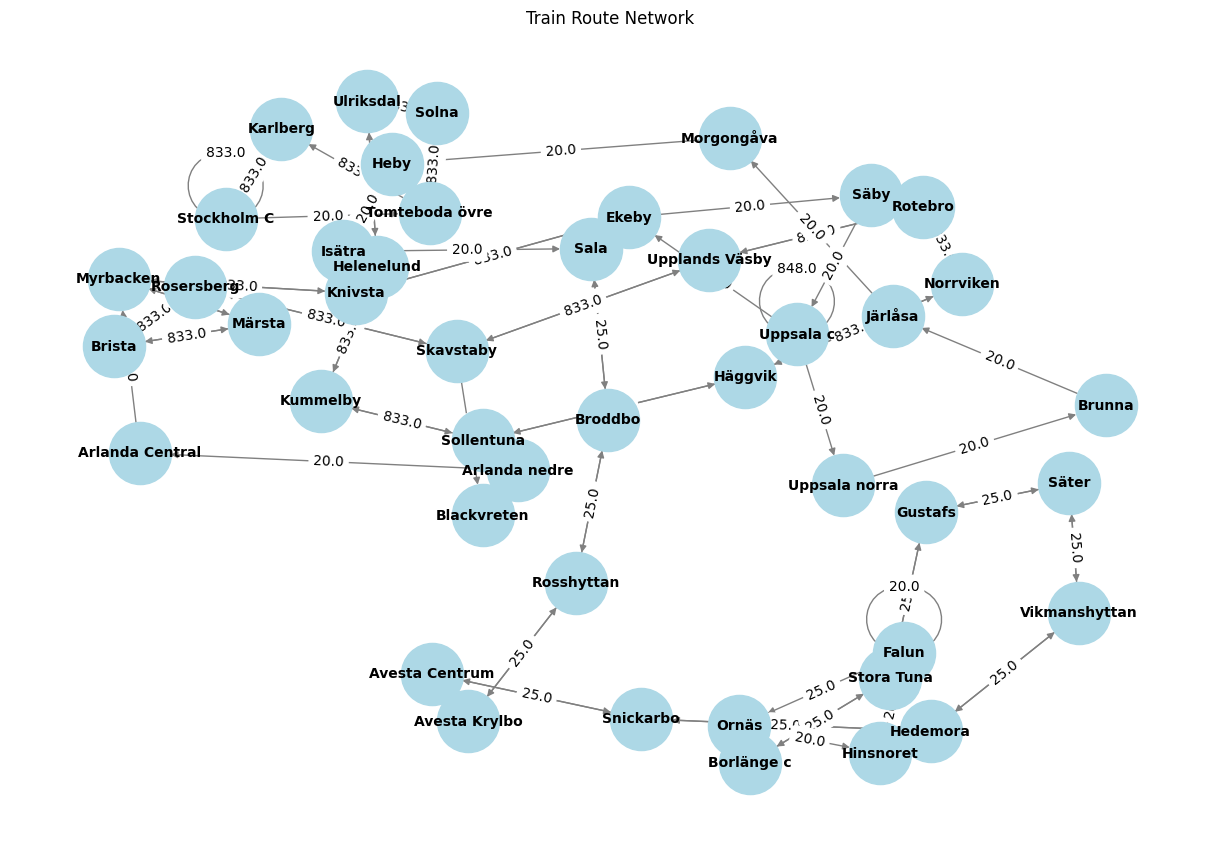

In [9]:
import networkx as nx

G = nx.DiGraph()

# Add edges for each route
for mission, routes in all_routes.items():
    for route in routes:
        stations = route.split(" -> ")
        for i in range(len(stations) - 1):
            G.add_edge(stations[i], stations[i + 1], mission=mission)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray", arrows=True)

# Show edge labels for mission types
edge_labels = nx.get_edge_attributes(G, 'mission')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Train Route Network")
plt.show()

In [10]:
#print all stations
all_stations = pd.concat([df['Avgångsplats'],df['Ankomstplats']]).unique()
print("unique station names:",all_stations)
len(all_stations)

#print specific staion is present or not
specific_station= 'Uppsala c'

if specific_station in all_stations:
    print(f"{specific_station} presents")

else:
    print(f"no")

#print station start with u
station_starting_with_u = [station for station in all_stations if str(station).startswith('U')]
print(station_starting_with_u)

unique station names: ['Helsingborg godsbangård' 'Malmö c' 'Gimonäs' ...
 'Meselefors campingplats' 'Malung' '-']
Uppsala c presents
['Uppsala c', 'Ulriksdal', 'Umeå godsbangård', 'Upplands Väsby', 'Ulvshyttan', 'Utsikten', 'Ulvstorp', 'Umeå', 'Uppsala norra', 'Umeå Östra', 'Uddevalla c', 'Uddevalla östra', 'Ursviken', 'Undersåker', 'Ulriksfors']


In [52]:
import numpy as np
#list of specific station
stations = ['Falun','Uppsala c','Stockholm C']

#time filtering
start_time = pd.to_datetime('07:00:00').time()
end_time = pd.to_datetime('19:00:00').time()

common_train_mission =  None

#loop through each train mission to get the common train mission

for station in stations:
    
    train_mission_at_station = df[(df['Avgångsplats']== station) | (df['Ankomstplats']== station)].copy()

    # Print the number of rows found for the current station
    print(f"\nNumber of rows for station '{station}': {len(train_mission_at_station)}")

    #filter mission within time frame
    train_mission_at_station.loc[:,'PlanAvgTid'] = pd.to_datetime( train_mission_at_station['PlanAvgTid'])
    train_mission_at_station.loc[:,'PlanAnkTid'] = pd.to_datetime( train_mission_at_station['PlanAnkTid'])

    filtered_missions = train_mission_at_station[(train_mission_at_station['PlanAvgTid'].dt.time >= start_time) &
                                                  (train_mission_at_station['PlanAvgTid'].dt.time <= end_time)|
                                                ((train_mission_at_station['PlanAnkTid'].dt.time >= start_time) &
                                                (train_mission_at_station['PlanAnkTid'].dt.time <= end_time))
    ]
    
    # Print the number of rows after time filtering
    print(f"Number of rows after time filtering for station '{station}': {len(filtered_missions)}")
 
    unique_train_missions = set(filtered_missions['Tåguppdrag'].unique())

    # Print the unique missions found for the current station
    print(f"Unique train missions at station '{station}': {unique_train_missions}")

    if common_train_mission is None:
        common_train_mission = unique_train_missions

    else:

        common_train_mission &= common_train_mission

common_train_mission = np.array(list(common_train_mission))

np.set_printoptions(suppress=True, formatter={'float_kind': lambda x: f"{x:.1f}"})
# Print the final common train missions
print("\nCommon train missions across all stations and time range:", common_train_mission)



Number of rows for station 'Falun': 3332
Number of rows after time filtering for station 'Falun': 1974
Unique train missions at station 'Falun': {np.float64(8192.0), np.float64(8194.0), np.float64(8195.0), np.float64(8201.0), np.float64(12.0), np.float64(8204.0), np.float64(14.0), np.float64(15.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(25.0), np.float64(53.0), np.float64(35896.0), np.float64(57.0), np.float64(62.0), np.float64(47167.0), np.float64(47169.0), np.float64(47198.0), np.float64(76418.0), np.float64(90760.0), np.float64(90761.0), np.float64(90765.0), np.float64(5782.0), np.float64(5784.0), np.float64(47263.0), np.float64(47269.0), np.float64(47271.0), np.float64(48317.0), np.float64(47299.0), np.float64(6875.0), np.float64(8186.0), np.float64(45807.0), np.float64(67311.0), np.float64(33010.0), np.float64(80127.0), np.float64(35590.0), np.float64(40729.0), np.float64(47397.0), np.float64(35624.0)